In [11]:
import os
import numpy as np
import warnings

# Note that you need the standard desi/conda dependencies + matplotlib, 
# basemap, and healpy to run this notebook.
import mpl_toolkits
import matplotlib.pyplot as plt

from desiutil.plots import init_sky, plot_sky_binned

%matplotlib inline

In [19]:
def getfits(fitsfile):
    import fitsio
    print('Reading {}'.format(fitsfile))
    dat = fitsio.read(fitsfile, ext=1, upper=True)
    return dat

In [24]:
def gethdf5(hdf5file):
    import h5py
    print('Reading {}'.format(hdf5file))
    f = h5py.File(hdf5file)
    ra  = f['Data/ra'][...].astype('f8') % 360.0
    dec = f['Data/dec'][...].astype('f8')
    rmag = f['Data/app_mag'][...].astype('f8')
    these = rmag < 20.1
    dat = {'RA': ra[these], 'DEC': dec[these]}
    return dat

In [25]:
# Read the mocks.
data = list()
mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 'desi_footprint', 'v0.0.3', 'BGS.hdf5')
data.append(gethdf5(mockfile))

for mock in ('ELG', 'LRG', 'QSO'):
    mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.4', '{}.fits'.format(mock))
    data.append(getfits(mockfile))

mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.1', '2048', 'random.fits')
data.append(getfits(mockfile))

Reading /Users/ioannis/research/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.3/BGS.hdf5
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.4/ELG.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.4/LRG.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.4/QSO.fits
Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits


In [14]:
def rendermap(cat, objtype):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k');
        plot_sky_binned(cat['RA'], cat['DEC'], verbose=False, 
                        clip_lo='!1', plot_type='healpix', cmap='jet', 
                        label=r'{} (targets/deg$^2$)'.format(objtype), 
                        basemap=basemap)      
        plt.show()

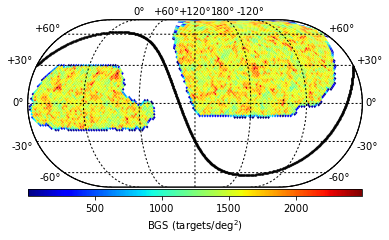

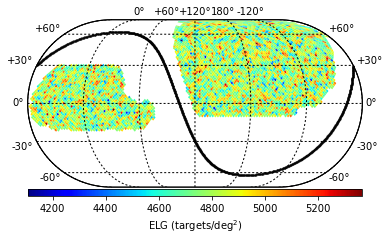

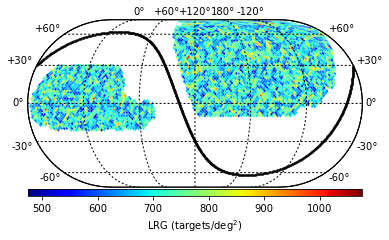

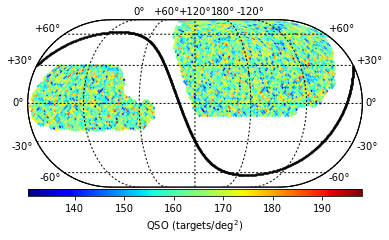

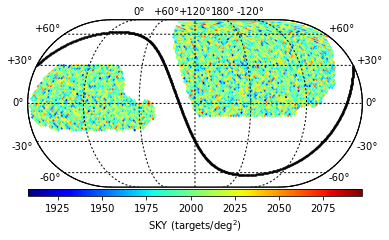

In [26]:
for cat, objtype in zip(data, ('BGS', 'ELG', 'LRG', 'QSO', 'SKY')):
    rendermap(cat, objtype)